In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
from scipy.stats import norm

token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [36]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Load data

In [37]:
cleansed=load_amihud_markets_price()

# Fong, Holden and Trzcinka (2010)

$$ FHT = 2 \sigma N^{-1} \left ( \frac{1+Z}{2} \right ) $$

Where $Z$ is the proportion of Zero days. and $N^{-1}()$ is the inverse of the cumulative normal function.

In [38]:
data=pd.DataFrame()
for c in cleansed.columns:
    x=cleansed[c].dropna().pct_change()
    nonzero=x[x==0].resample(rule='m',how='count')
    Z=(nonzero/x.resample(rule='m',how='count')).dropna()
    data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
    

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


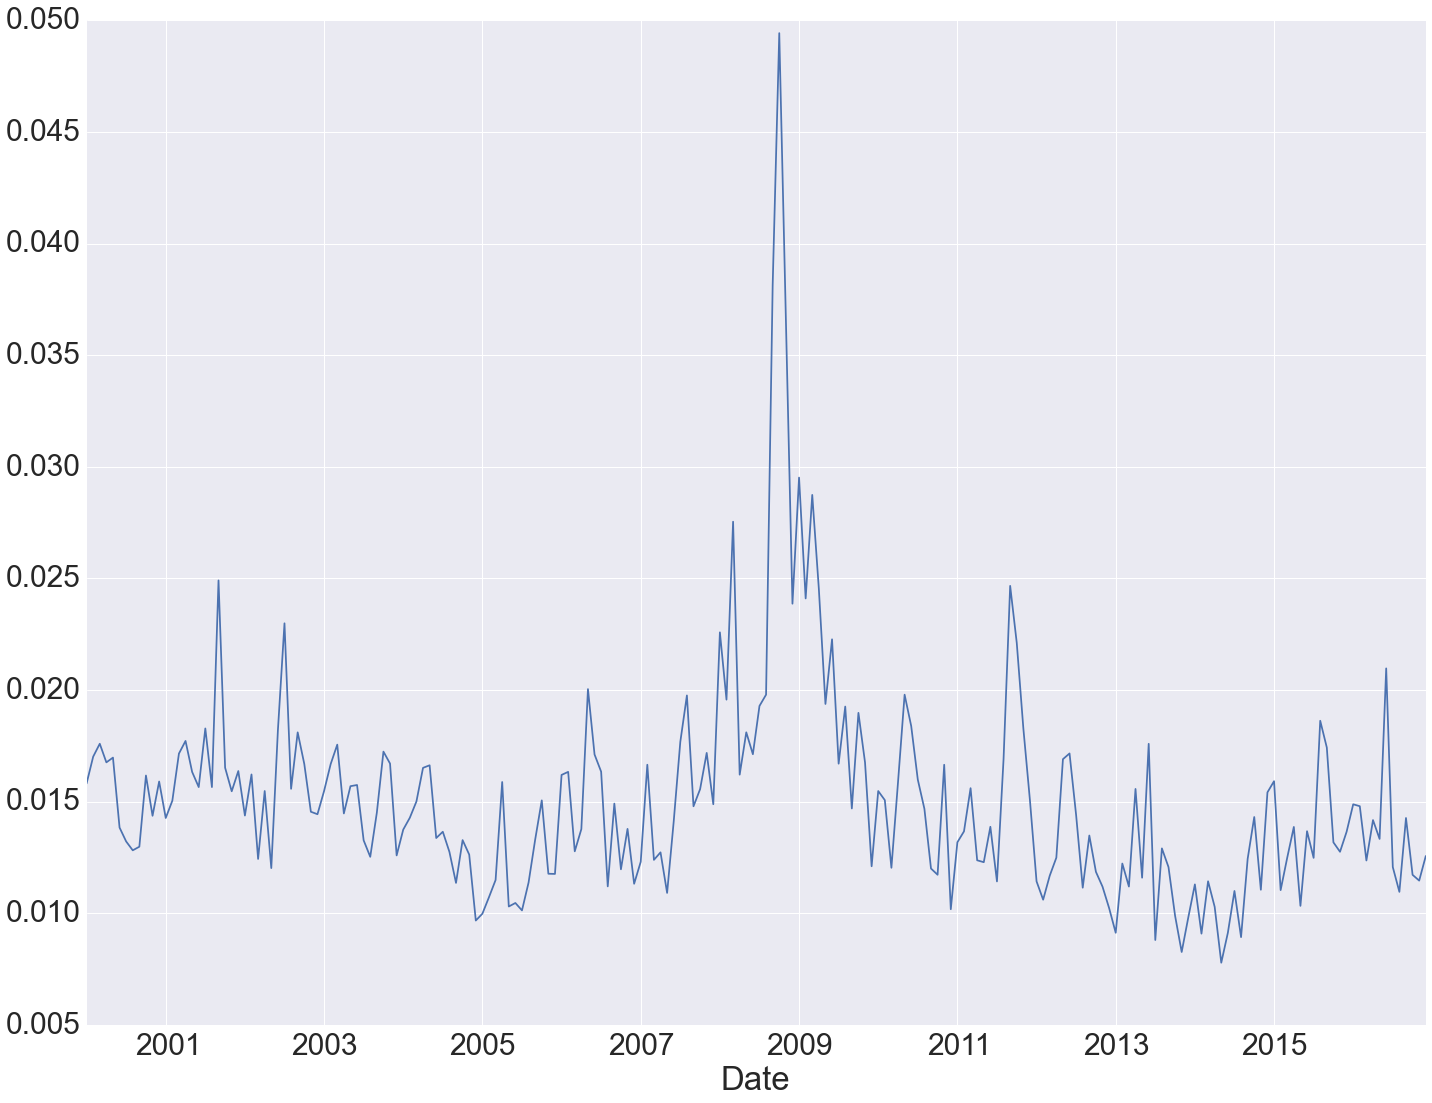

In [5]:
data['2000':'2016'].median(axis=1).plot()

In [6]:
df=pd.DataFrame()
mp =load_maps()
for sect in mp.Sector.unique():
    ind=mp[mp.Sector==sect].index
    new_ind=[]
    for i in ind:
        if i in data.columns:
            new_ind.append(i)
    df[sect]=data[new_ind].median(axis=1)

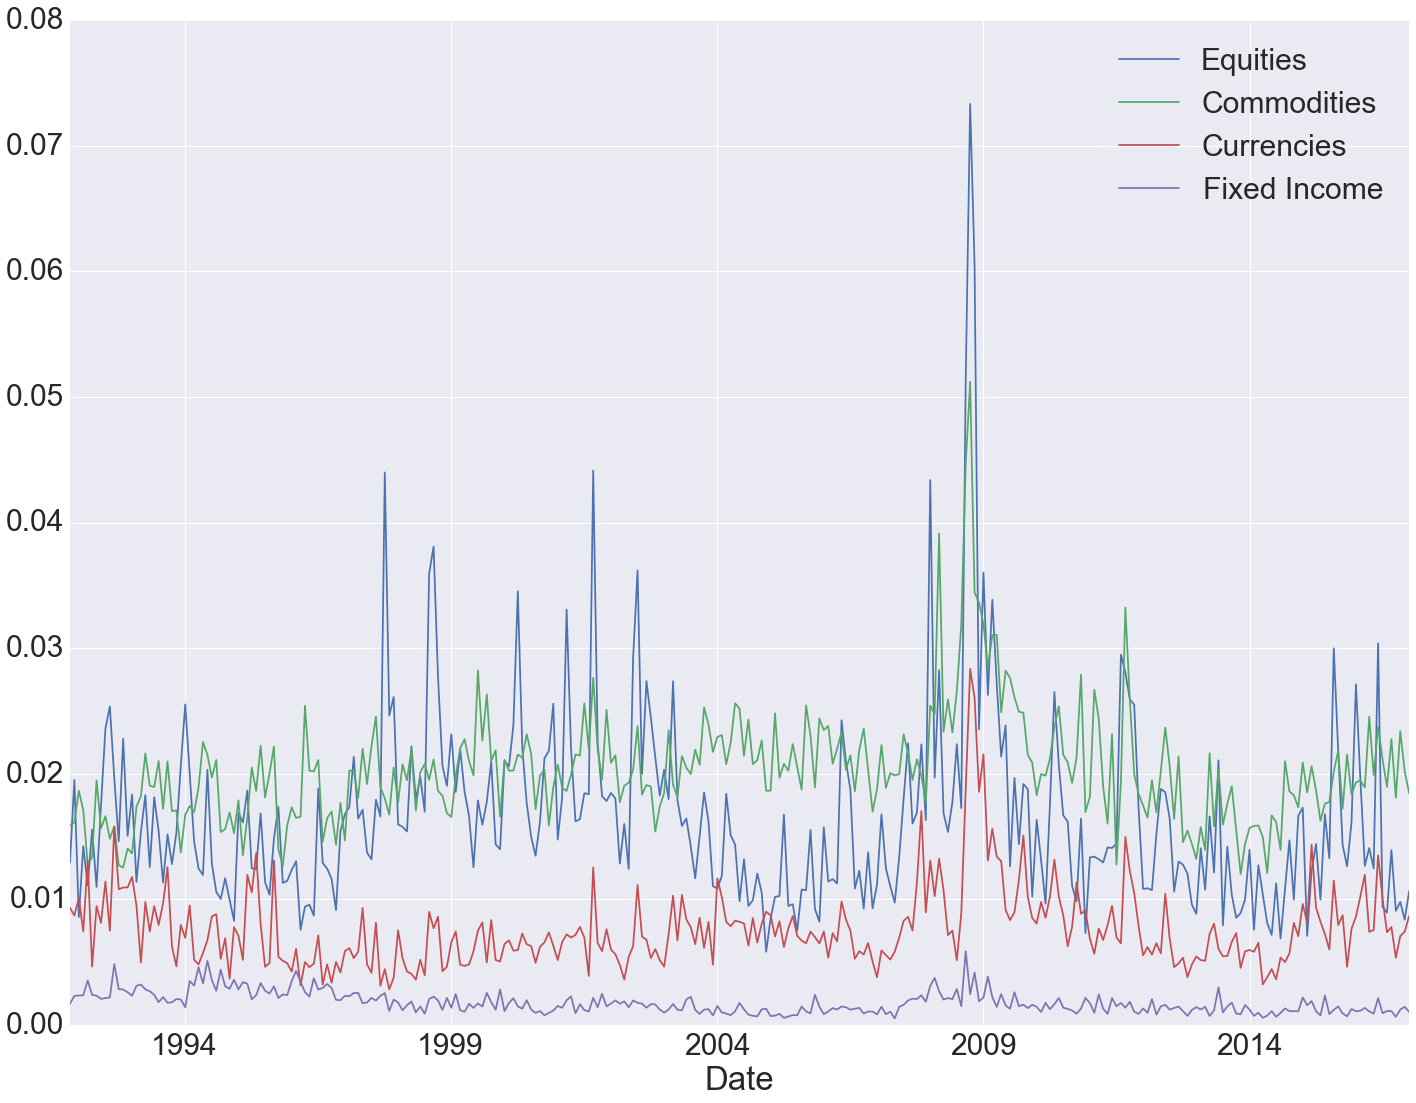

In [7]:
df.dropna().plot()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


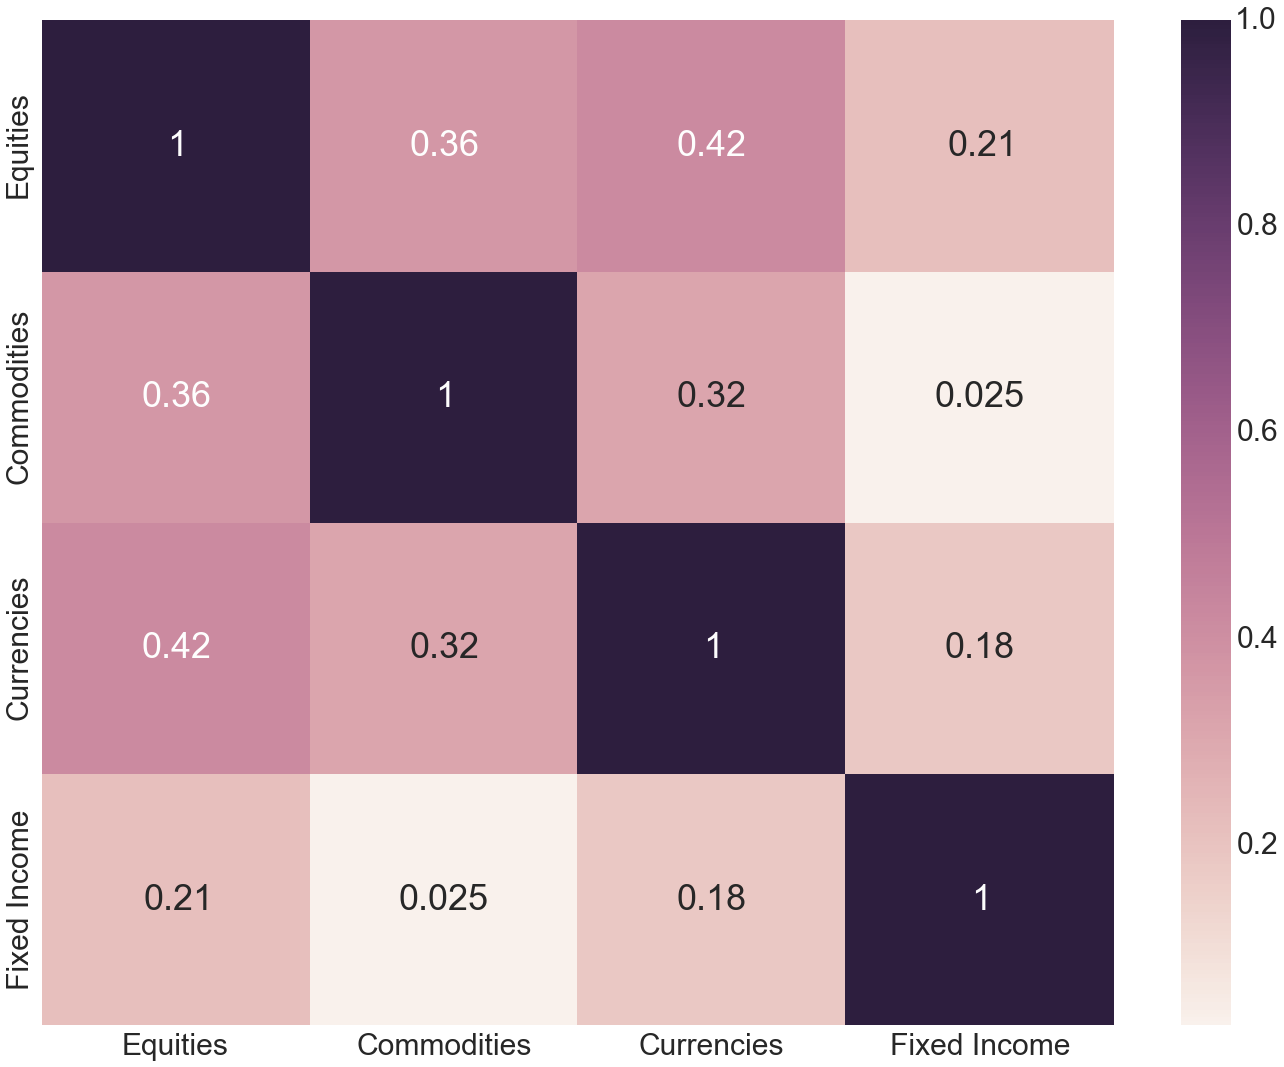

In [8]:
sns.heatmap(df.diff().corr(),annot=True)

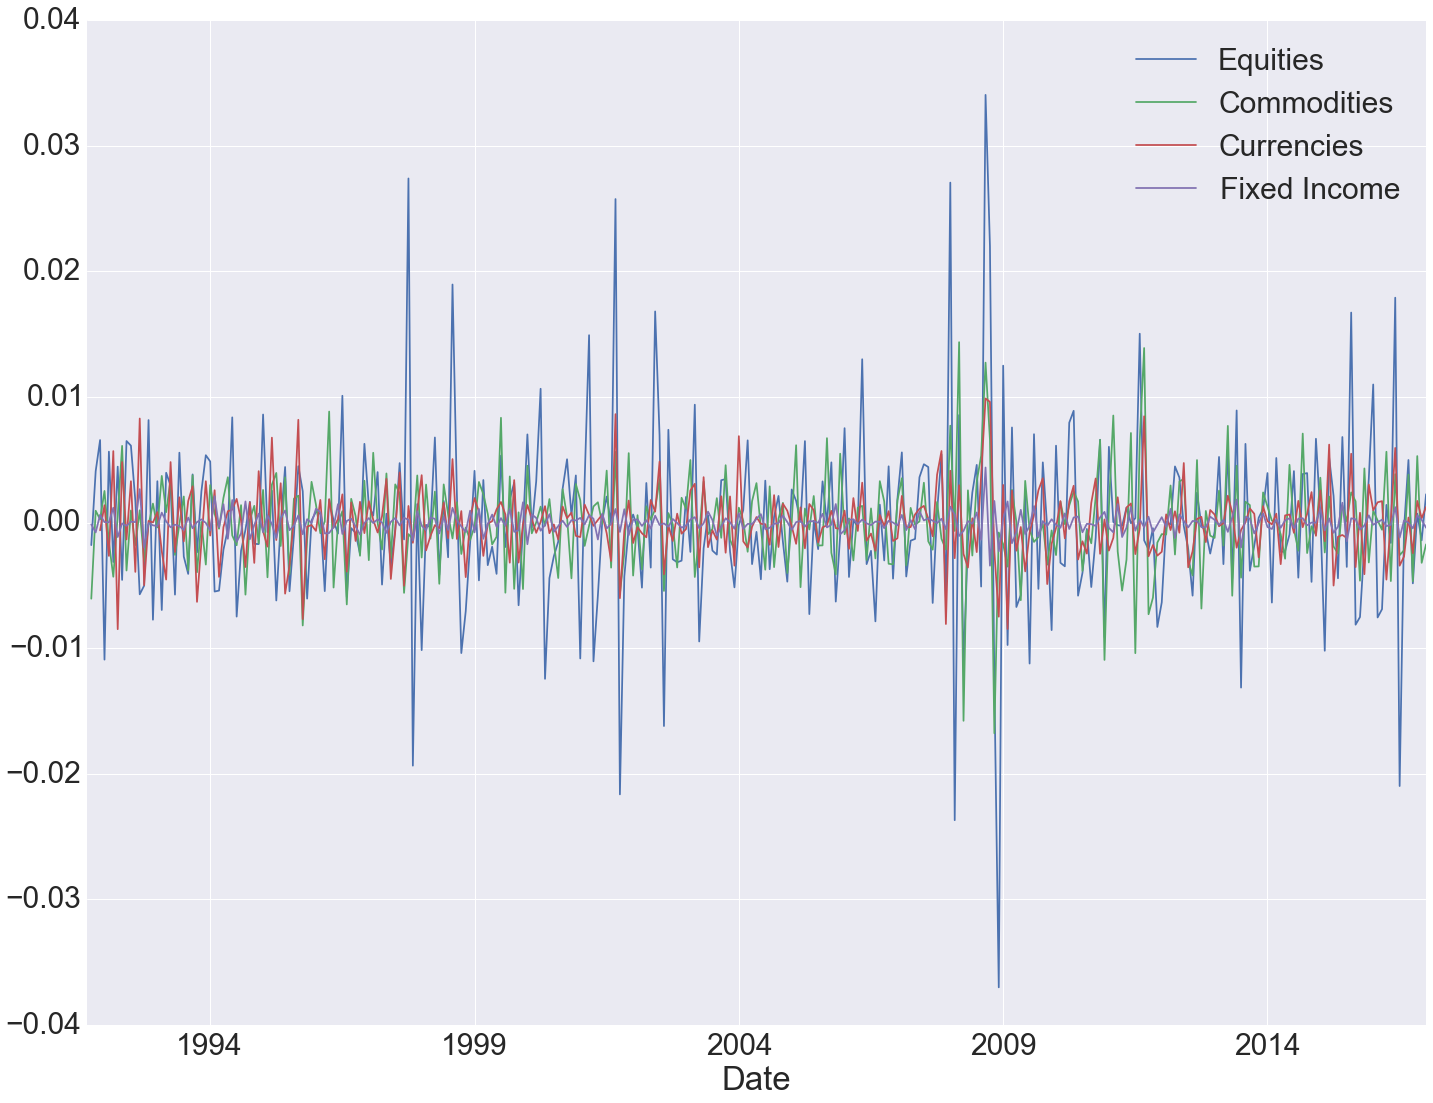

In [9]:
df.diff().plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c67fbd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10d2e7a10>]], dtype=object)

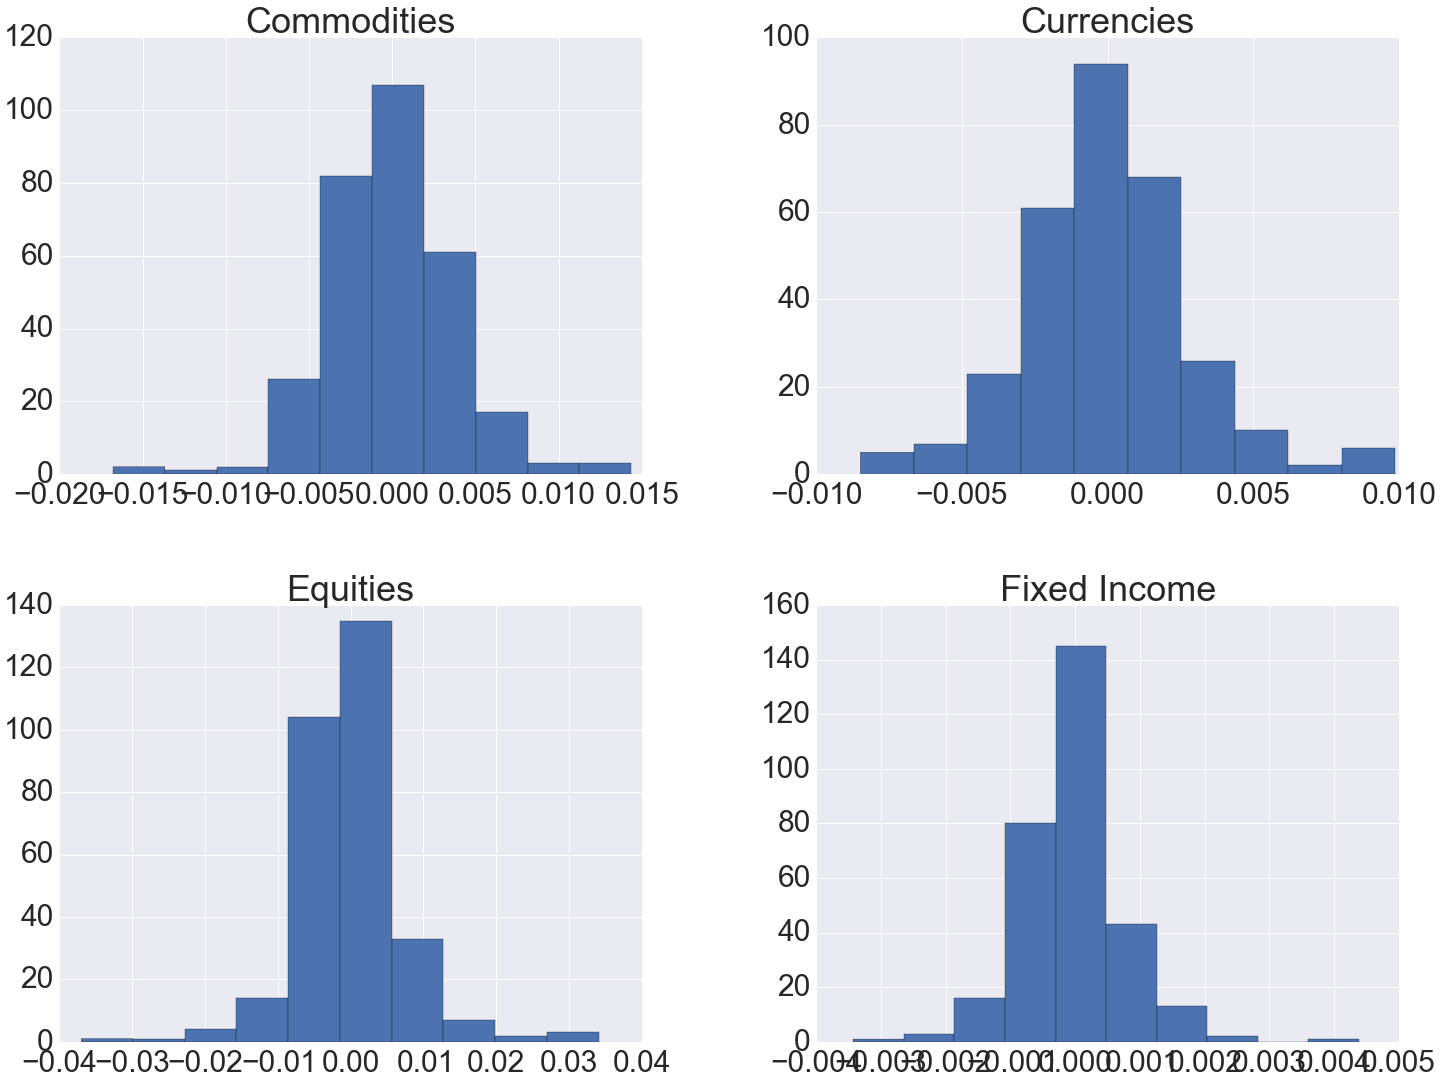

In [10]:
df.diff().hist()

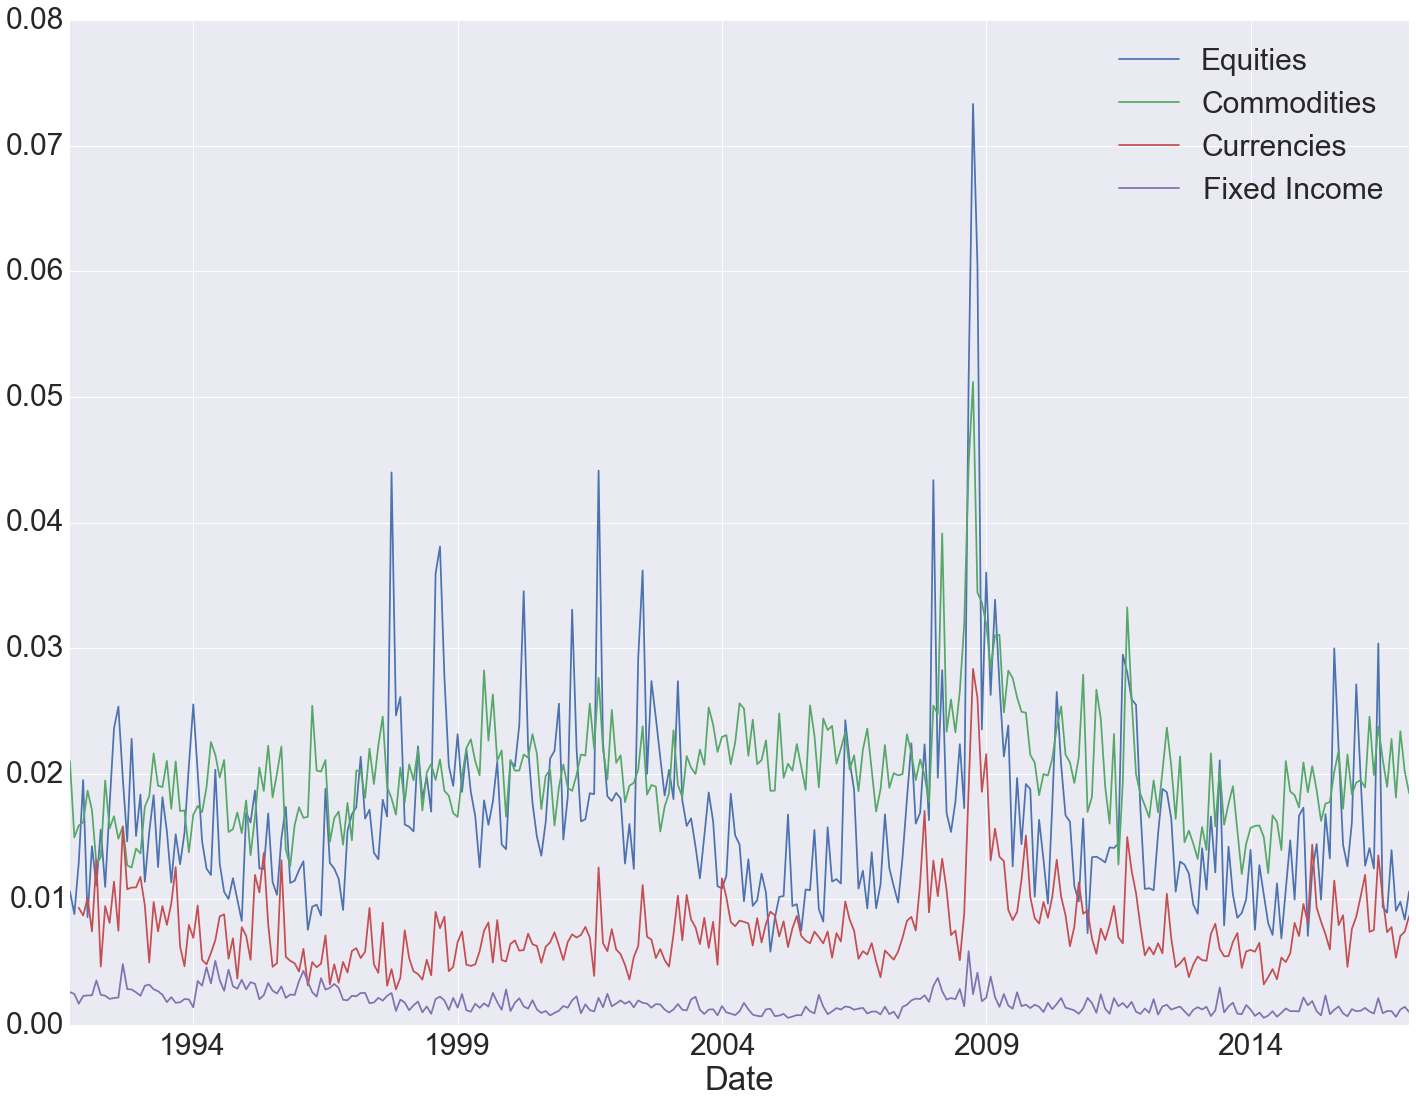

In [11]:
df.plot()

In [12]:
stats=pd.DataFrame()
stats['Mean']=df.mean()
stats['Standard Deviation']=df.std()
stats['Skew']=df.skew()
stats['Kurtosis']=df.kurt()

In [13]:
stats.round(4)

Mean  Standard Deviation    Skew  Kurtosis
Equities      0.0167              0.0079  2.7193   12.5467
Commodities   0.0203              0.0046  2.0748    9.8021
Currencies    0.0076              0.0033  2.2874    9.2514
Fixed Income  0.0018              0.0009  1.3210    2.4008

In [14]:
print stats.round(4).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &    Mean &  Standard Deviation &    Skew &  Kurtosis \\
\midrule
Equities     &  0.0167 &              0.0079 &  2.7193 &   12.5467 \\
Commodities  &  0.0203 &              0.0046 &  2.0748 &    9.8021 \\
Currencies   &  0.0076 &              0.0033 &  2.2874 &    9.2514 \\
Fixed Income &  0.0018 &              0.0009 &  1.3210 &    2.4008 \\
\bottomrule
\end{tabular}



In [15]:
stats.to_csv('FHT.csv')

In [16]:
df.dropna().to_csv('FHT_ts.csv')

# Running AR(2) numbers

Technique from Korajczyk and Sadka (2008)

In [17]:
import statsmodels.api as sm

In [18]:
residual=pd.DataFrame()
for sec in df.columns:
    shif=df[sec].shift(2).dropna()
    res=sm.OLS(shif,df[sec].ix[shif.index]).fit()
    print res.params
    residual[sec]=res.resid


Equities    0.891916
dtype: float64
Commodities    0.97831
dtype: float64
Currencies    0.926626
dtype: float64
Fixed Income    0.92888
dtype: float64


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


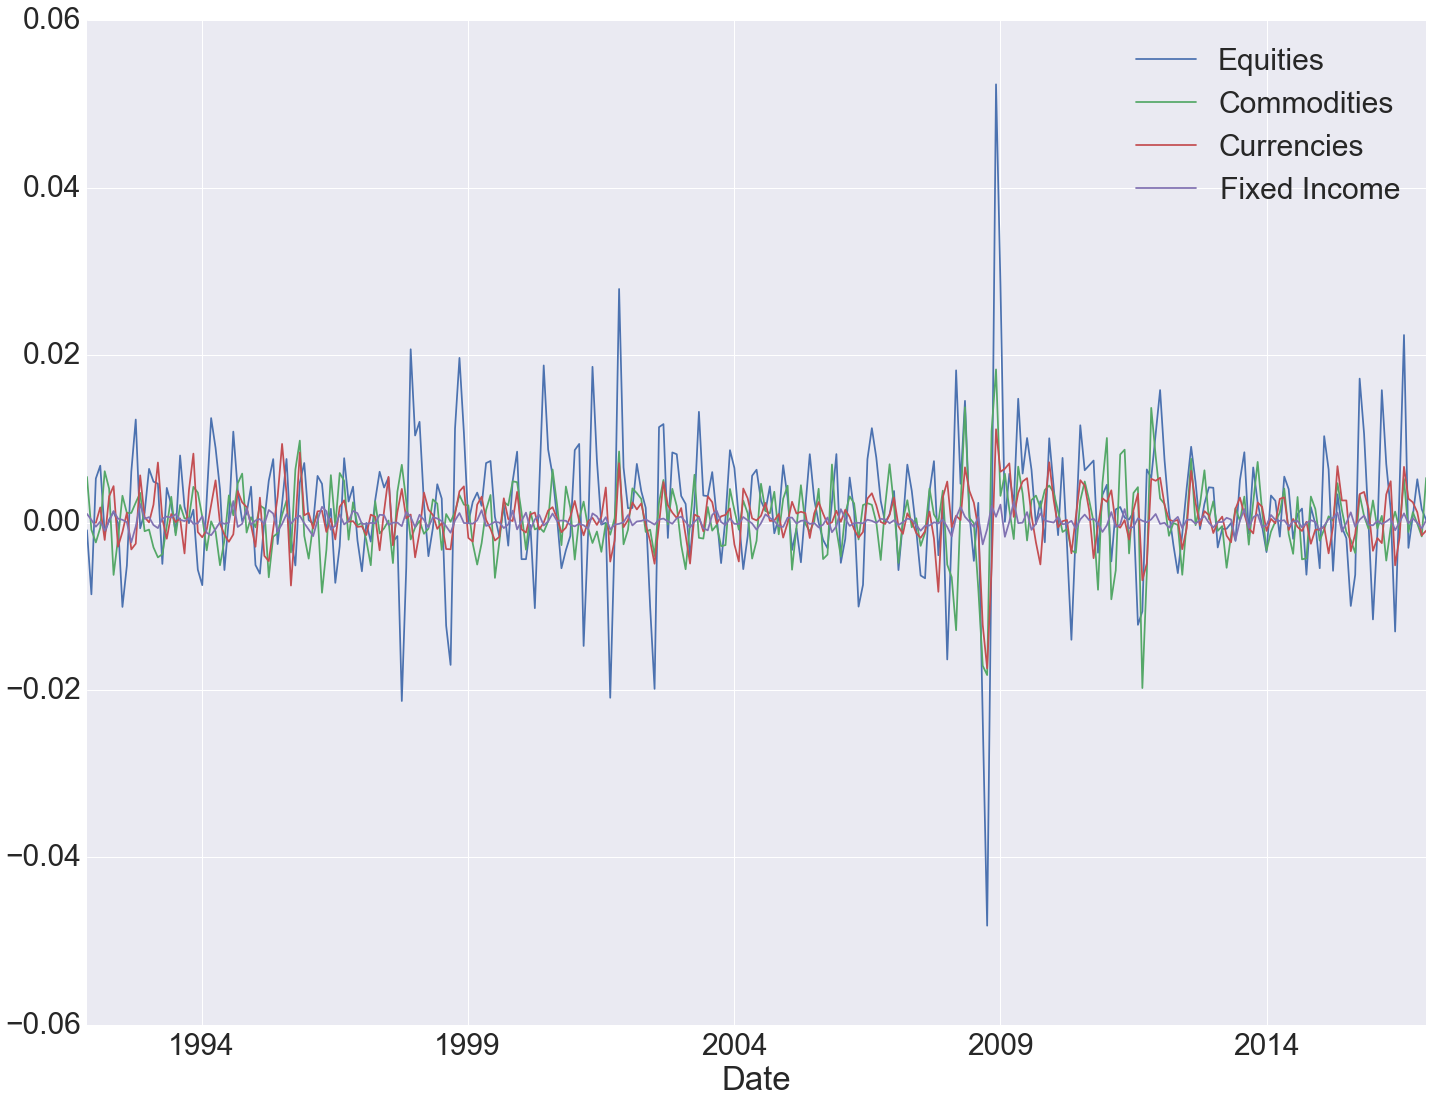

In [19]:
residual.plot()

# Standardize factors by rolling zscore
I use expanding window as per Korajczyk and Sadka 2008



In [25]:
zscore_markets=calc_zscore_expanding_window(data.dropna(how='all'))
zscore_sector=pd.DataFrame()
d_map=sector_map(zscore_markets)
for sect in d_map.keys():
    zscore_sector[sect]=zscore_markets[d_map[sect]].mean(axis=1)

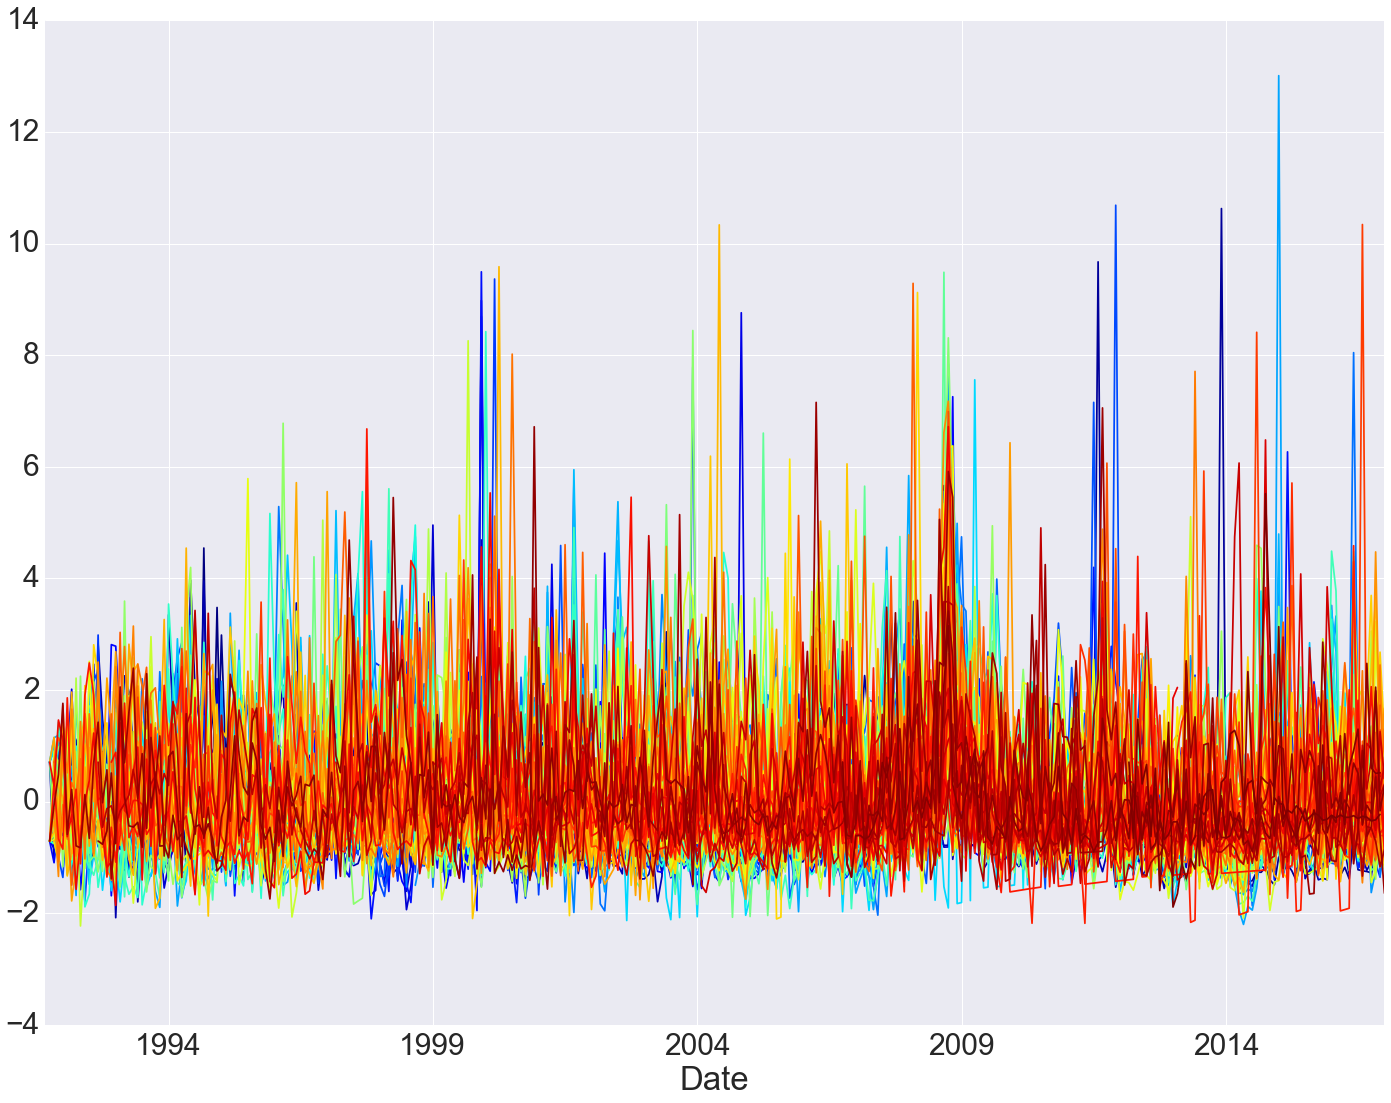

In [26]:
zscore_markets.plot(colormap='jet',legend=False)

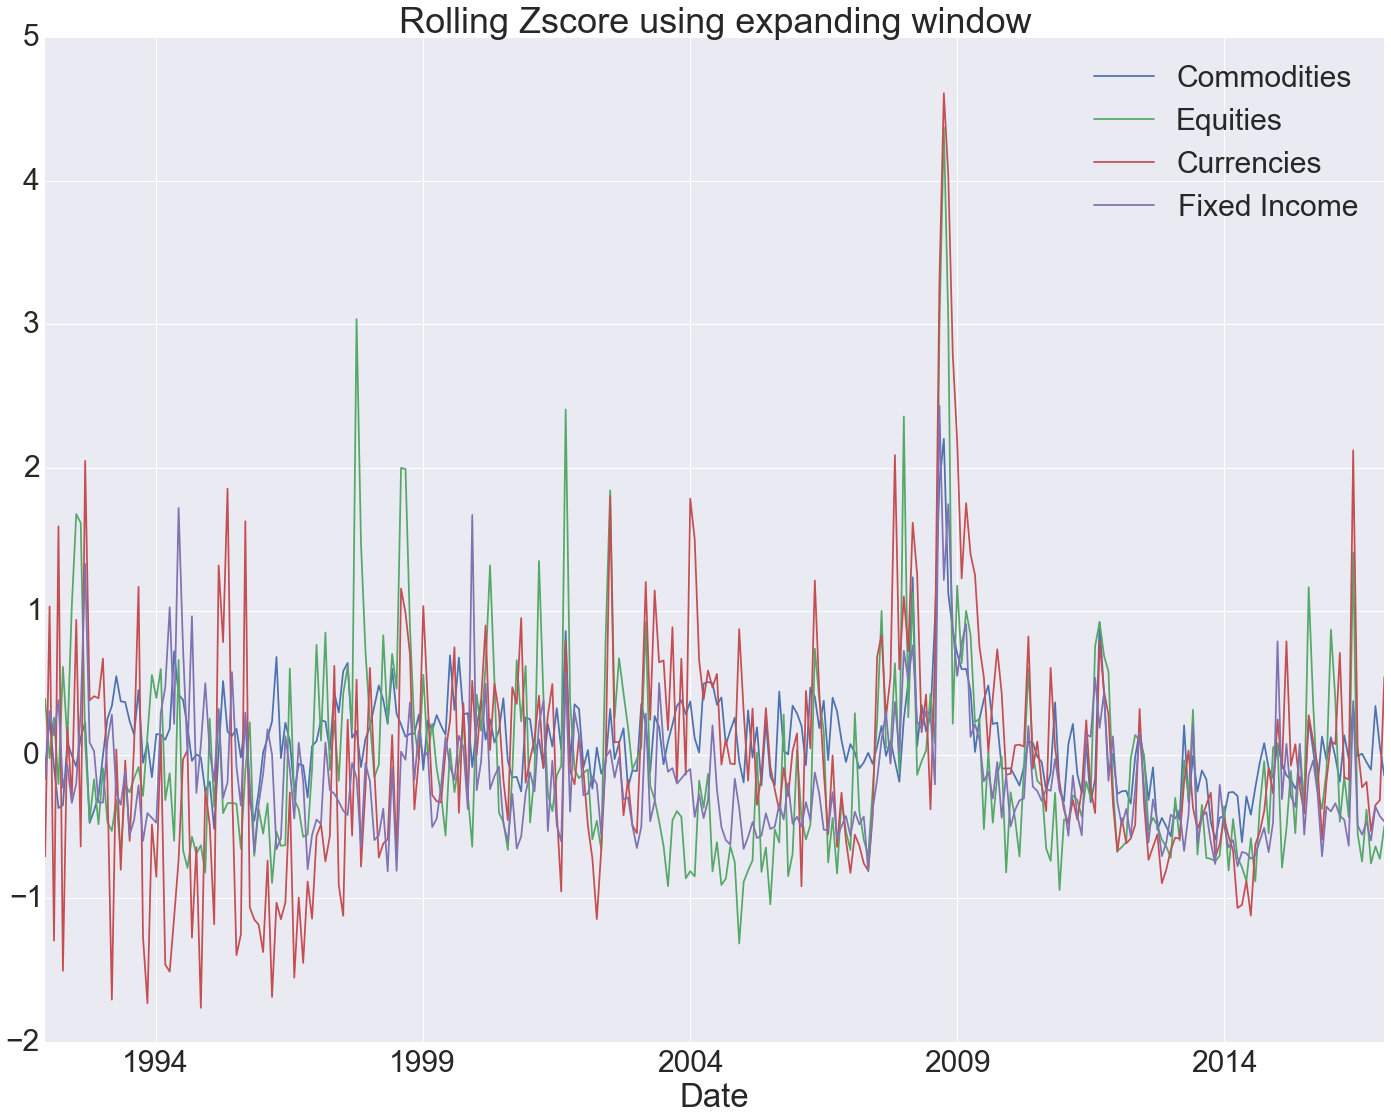

In [27]:
zscore_sector.dropna().plot(title='Rolling Zscore using expanding window')

In [28]:
zscore_markets=calc_zscore_ew(data.dropna(how='all'))
zscore_sector=pd.DataFrame()
d_map=sector_map(zscore_markets)
for sect in d_map.keys():
    zscore_sector[sect]=zscore_markets[d_map[sect]].mean(axis=1)

tsmom_model.py:263: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=12,adjust=True,com=24).mean()
  return (df-pd.ewma(df,lookback,min_periods=12))/pd.ewmstd(df,lookback,min_periods=12)
tsmom_model.py:263: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=12,adjust=True,com=24).std(bias=False)
  return (df-pd.ewma(df,lookback,min_periods=12))/pd.ewmstd(df,lookback,min_periods=12)


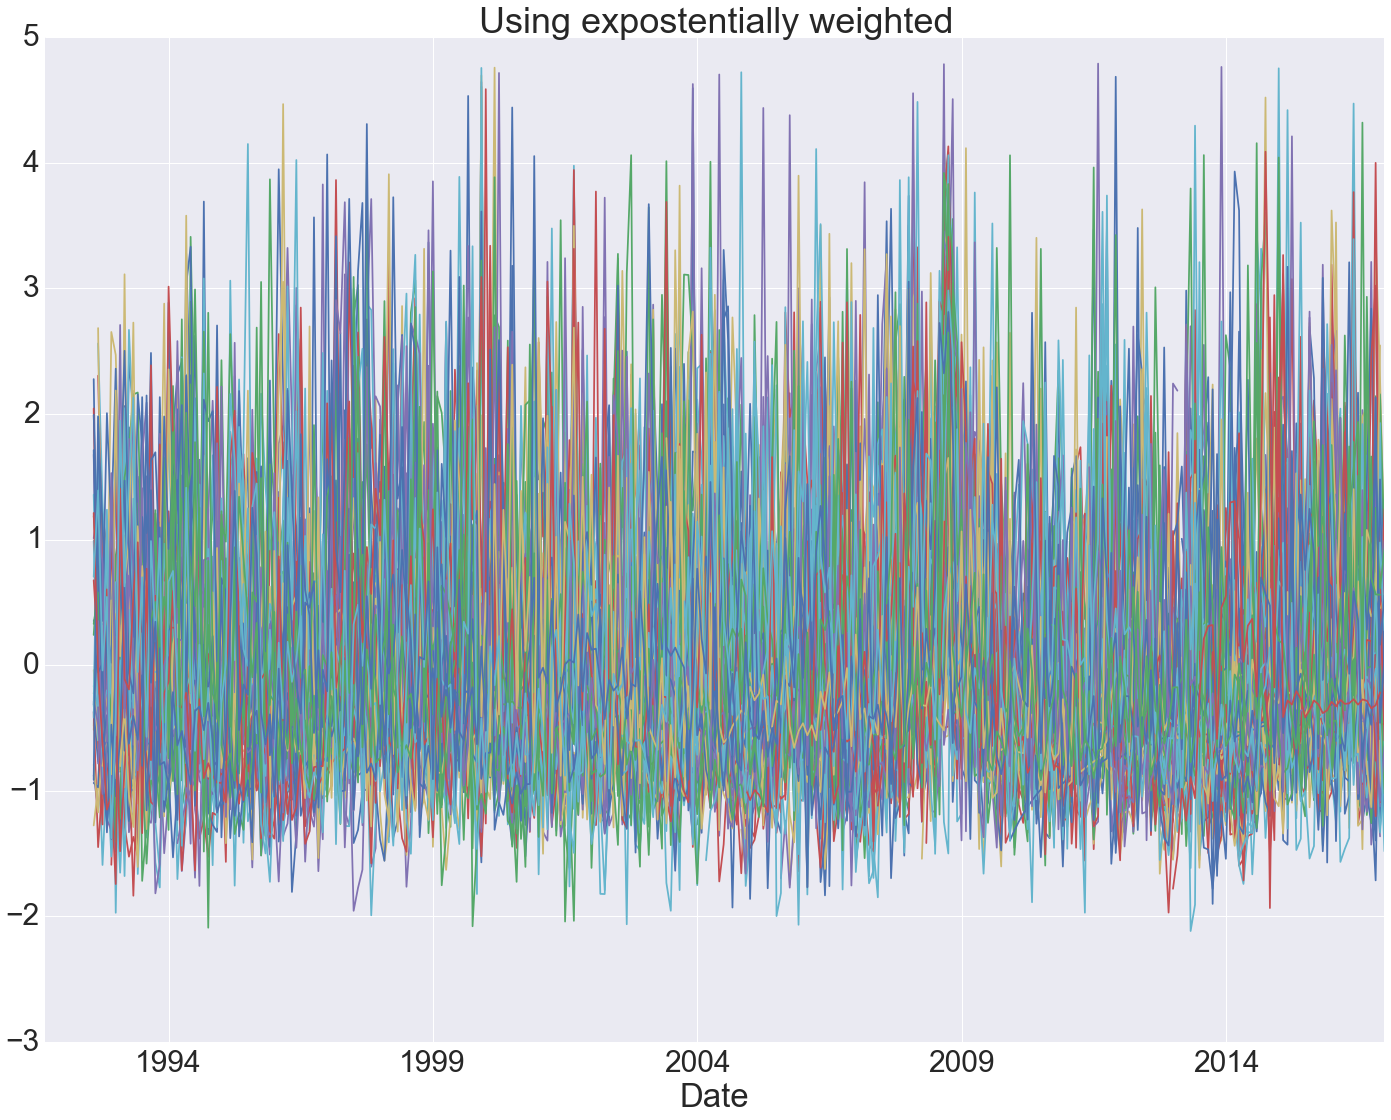

In [29]:
zscore_markets.plot(title='Using expostentially weighted',legend=False)

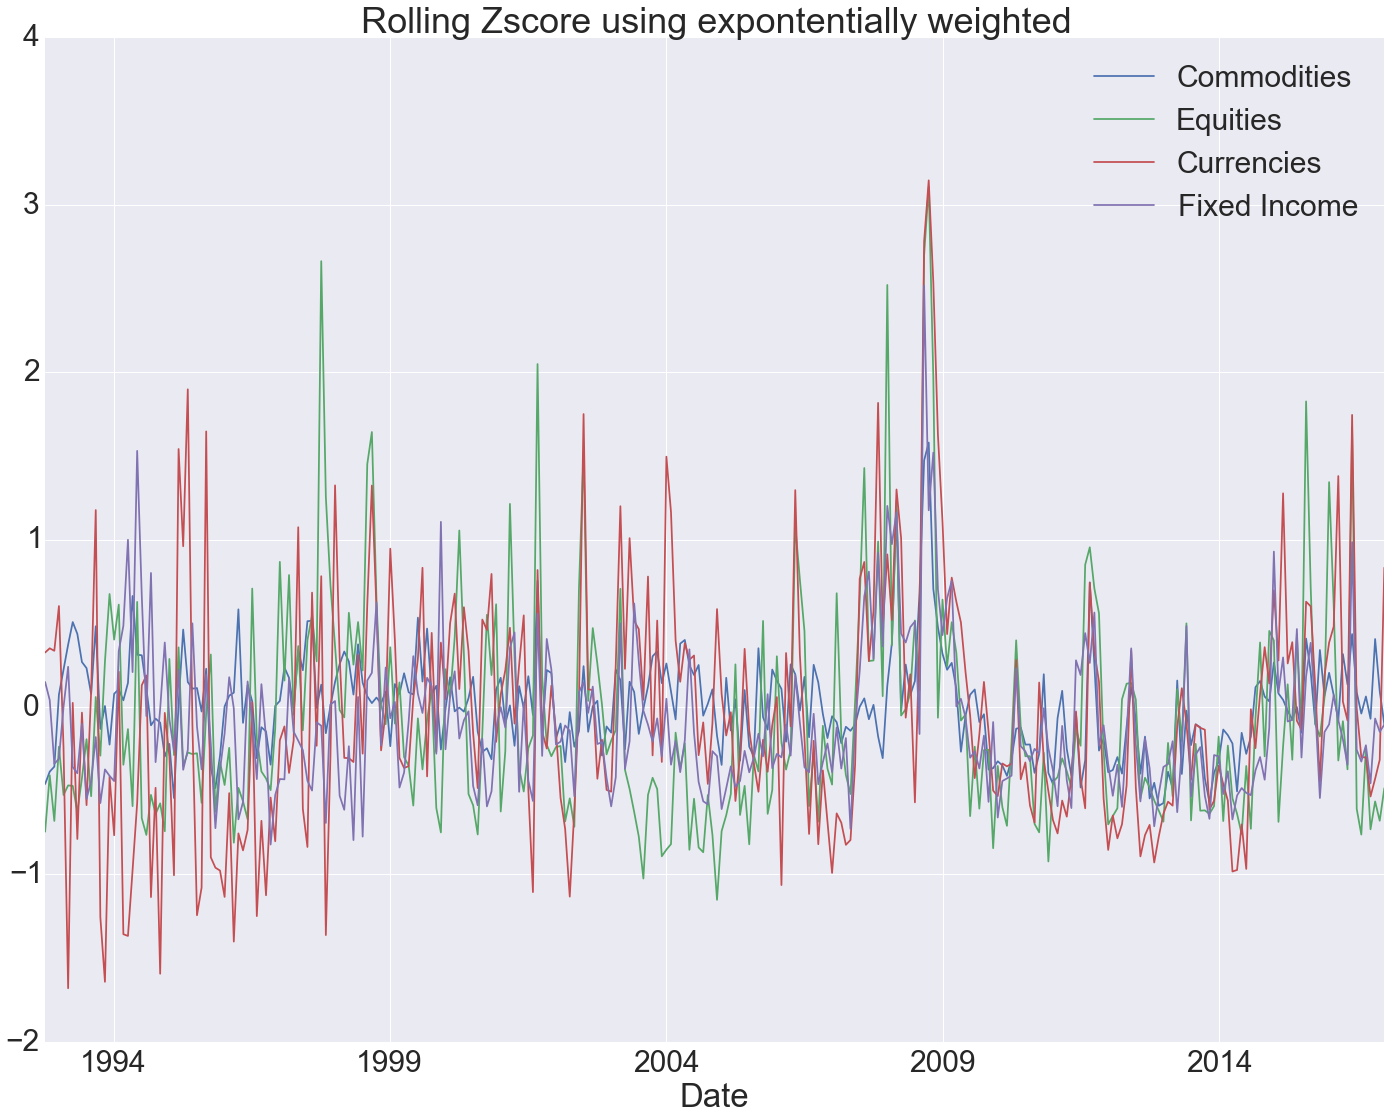

In [30]:
zscore_sector.dropna().plot(title='Rolling Zscore using expontentially weighted')

In [31]:
zscore_sector.corr()

Commodities  Equities  Currencies  Fixed Income
Commodities      1.000000  0.437016    0.455407      0.450705
Equities         0.437016  1.000000    0.494297      0.493811
Currencies       0.455407  0.494297    1.000000      0.511697
Fixed Income     0.450705  0.493811    0.511697      1.000000

# Checking how much autocorrelation there is even in the zscore model

In [34]:
residual=pd.DataFrame()
for sec in zscore_sector.columns:
    shif=zscore_sector[sec].shift(2).dropna()
    res=sm.OLS(shif,zscore_sector[sec].ix[shif.index]).fit()
    print res.params
    residual[sec]=res.resid

Commodities    0.390098
dtype: float64
Equities    0.336454
dtype: float64
Currencies    0.312392
dtype: float64
Fixed Income    0.447955
dtype: float64


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


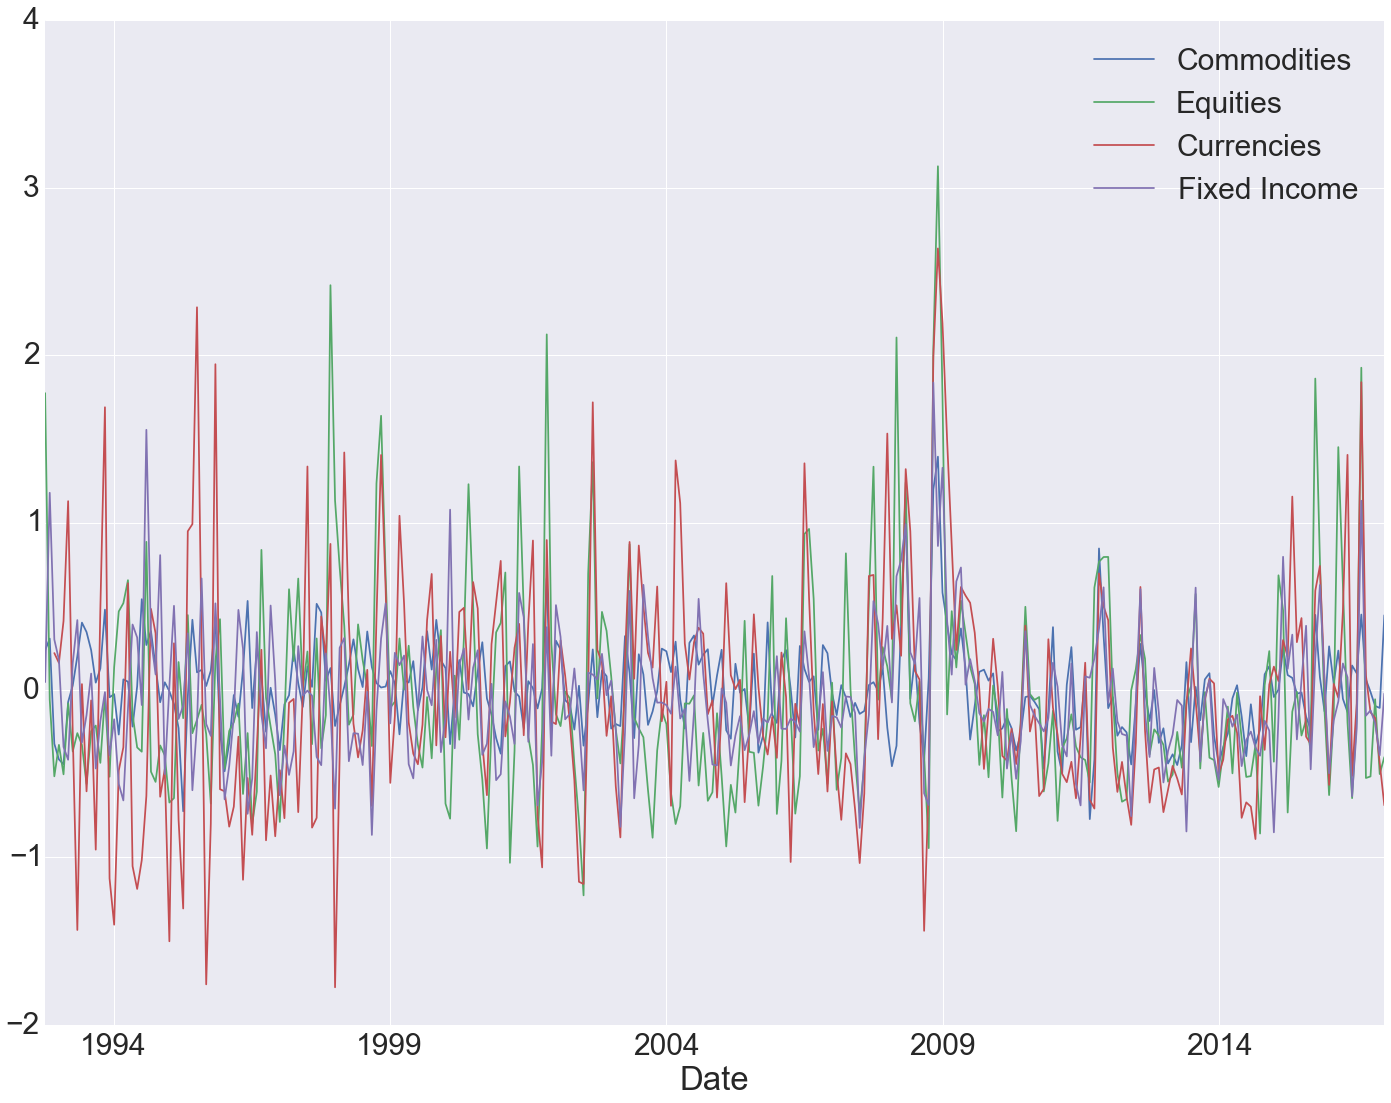

In [35]:
residual.plot()